# Lecture3 A Deeper Look at Word Vectors

这节课从传统的基于计数的全局方法出发，过渡到结合两者优势的GloVe，并介绍了词向量的调参与评测方法。

### 复习：word2vec的主要思路

- 遍历整个语料库中的每个词
- 预测每个词的上下文
- ![屏幕快照 2018-04-14 下午1.55.55.png](https://i.loli.net/2018/04/14/5ad197faaaf6c.png)
- 在每个窗口中计算梯度做SGD

### 随机梯度和词向量

每个窗口最多只有2m+1个单词，所以$∇θJ_{t}(θ)$会非常稀疏

![屏幕快照 2018-04-14 下午2.00.06.png](https://i.loli.net/2018/04/14/5ad198f1022c5.png)

### 近似：负采样

还有一个问题亟待解决，词表V的量级非常大，以至于下式的分母很难计算：

![屏幕快照 2018-04-14 下午1.55.55.png](https://i.loli.net/2018/04/14/5ad197faaaf6c.png)

于是，练习1中要求用negative sampling实现skip-gram。这是一种采样子集简化运算的方法。具体做法是，对每个正例（中央词语及上下文中的一个词语）采样几个负例（中央词语和其他随机词语），训练binary logistic regression（也就是二分类器）。

### word2vec通过把相似的词语放到同一个地方附近来增大目标函数：

![006Fmjmcly1fgdw0ao8ufj31ea0uk4qp.jpg](https://i.loli.net/2018/04/14/5ad1a1d96bcb3.jpg)

### 其他方法

word2vec将窗口视作训练单位，每个窗口或者几个窗口都要进行一次参数更新。要知道，很多词串出现的频次是很高的。能不能遍历一遍语料，迅速得到结果呢？

早在word2vec之前，就已经出现了很多得到词向量的方法，这些方法是基于统计共现矩阵的方法。如果在窗口级别上统计词性和语义共现，可以得到相似的词。如果在文档级别上统计，则会得到相似的文档（潜在语义分析LSA）。

### 基于窗口的共现矩阵

比如窗口半径为1，在如下句子上统计共现矩阵：

- I like deep learning. 
- I like NLP.
- I enjoy flying.

会得到：

![屏幕快照 2018-04-14 下午2.49.48.png](https://i.loli.net/2018/04/14/5ad1a4a14c485.png)

### 朴素共现向量的问题

根据这个矩阵，的确可以得到简单的共现向量。但是它存在非常多的局限性：

- 当出现新词的时候，以前的旧向量连维度都得改变
- 高纬度（词表大小）
- 高稀疏性

### 解决方法：低维向量

用25到1000的低维稠密向量来储存重要信息。

### 方法1：X上的维度降低

共生矩阵X的奇异值分解。

![屏幕快照 2018-04-14 下午3.01.55.png](https://i.loli.net/2018/04/14/5ad1a78a09d02.png)

### Python简单奇异值分解词向量

语料：

> I like deep learning. I like NLP. I enjoy flying.


In [1]:
import numpy as np
la = np.linalg
words = ["I", "like", "enjoy", "deep", "learning", "NLP", "flying", "."]
X = np.array([[0,2,1,0,0,0,0,0],
			  [2,0,0,1,0,1,0,0],
			  [1,0,0,0,0,0,1,0],
			  [0,1,0,0,1,0,0,0],
			  [0,0,0,1,0,0,0,1],
			  [0,1,0,0,0,0,0,1],
			  [0,0,1,0,0,0,0,1],
			  [0,0,0,0,1,1,1,0]])

U, s, Vh = la.svd(X, full_matrices=False)

输出对应于2个最大奇异值的U的前两列

-0.572859144537 -0.572859144537 I
0.630120663563 0.630120663563 like
0.274017533217 0.274017533217 enjoy
-0.247912130379 -0.247912130379 deep
0.0338495047559 0.0338495047559 learning
-0.293988989917 -0.293988989917 NLP
-0.161027766821 -0.161027766821 flying
0.157254761836 0.157254761836 .


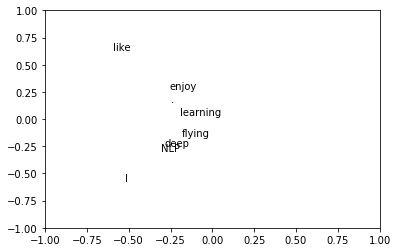

In [2]:
import matplotlib.pyplot as plt
for i in range(len(words)):
	print(U[i,1], U[i,1], words[i])
	plt.text(U[i,0], U[i,1], words[i])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

问题：功能词（the，he，has）出现过于频繁表明语法影响太大

改进：

- 限制高频词的频次，或者干脆停用词
- 根据与中央词的距离衰减词频权重
- 用皮尔逊相关系数代替词频，然后将负值设置为0

### 有趣的语义模式出现在向量中

![屏幕快照 2018-04-14 下午4.38.46.png](https://i.loli.net/2018/04/14/5ad1be56ae5d8.png)

![屏幕快照 2018-04-14 下午4.39.02.png](https://i.loli.net/2018/04/14/5ad1be569dc2b.png)

![屏幕快照 2018-04-14 下午4.39.08.png](https://i.loli.net/2018/04/14/5ad1be5681240.png)

### SVD的问题

- 计算复杂度高：对n×m的矩阵是$O(mn^{2})$
- 不方便处理新词或新文档
- 与其他DL模型训练套路不同

### Count based vs direct prediction

这些基于计数的方法在中小规模语料训练很快，有效地利用了统计信息。但用途受限于捕捉词语相似度，也无法拓展到大规模语料。

而NNLM, HLBL, RNN, Skip-gram/CBOW这类进行预测的模型必须遍历所有的窗口训练，也无法有效利用单词的全局统计信息。但它们显著地提高了上级NLP任务，其捕捉的不仅限于词语相似度。

### 综合两者优势：GloVe

这种模型的目标函数为：

![屏幕快照 2018-04-14 下午4.44.49.png](https://i.loli.net/2018/04/14/5ad1bf8e754fe.png)

这里的$P_{ij}$是两个词共现的频次，f是一个max函数：

![006Fmjmcly1fge0jnuvw6j30ig0a074y.jpg](https://i.loli.net/2018/04/14/5ad1c006a7186.jpg)

优点：

- 训练快
- 可以拓展到大规模语料
- 也适用于小规模语料和小向量。

这里面有两个向量$u$和$v$，它们都捕捉了共现信息，怎么处理呢？试验证明，最佳方案是简单地加起来：

$$X_{final}=U+V$$

相对于word2vec只关注窗口内的共现，GloVe这个命名也说明这是全局的。

### 如何评测词向量

- 与NLP中的一般评估相关：内在vs外在
- 内在：
    - 对特定/中间子任务的评估
    - 计算速度快•有助于理解该系统
    - 不清楚是否确实有用，除非建立与实际任务的相关性
- 外在：
    - 评估一个真实的任务
    - 可能需要很长时间才能计算出准确性
    - 不清楚子系统是否存在问题或者其相互作用或其他子系统
    - 需要至少两个subsystems同时证明
    - 这类评测中，往往会用pre-train的向量在外部任务的语料上retrain。

### 内部词向量评测

也就是词向量类推，或说“A对于B来讲就相当于C对于哪个词？”。这可以通过余弦夹角得到：

![屏幕快照 2018-04-14 下午5.04.23.png](https://i.loli.net/2018/04/14/5ad1c424d6844.png)

这种方法可视化出来，会发现这些类推的向量都是近似平行的：

- 男女名词

    ![屏幕快照 2018-04-14 下午5.00.28.png](https://i.loli.net/2018/04/14/5ad1c36f785d1.png)

- 公司-CEO

    ![屏幕快照 2018-04-14 下午5.00.55.png](https://i.loli.net/2018/04/14/5ad1c36fd435d.png)
    
- 语法类比

    ![屏幕快照 2018-04-14 下午5.00.45.png](https://i.loli.net/2018/04/14/5ad1c36fe1370.png)

- 其他有趣的类比

    ![屏幕快照 2018-04-14 下午5.01.04.png](https://i.loli.net/2018/04/14/5ad1c37374e78.png)

这在数学上是没有证明的。

### 结果对比

![屏幕快照 2018-04-14 下午5.05.59.png](https://i.loli.net/2018/04/14/5ad1c48d177cf.png)

GloVe的效果显著地更好。另外，高纬度并不一定好。而数据量越多越好。

### 调参

窗口是否对称（还是只考虑前面的单词），向量维度，窗口大小：

![屏幕快照 2018-04-14 下午5.07.05.png](https://i.loli.net/2018/04/14/5ad1c4e407106.png)

大约300维，窗口大小8的对称窗口效果挺好的，考虑到成本。

对GloVe来讲，迭代次数越多越小，效果很稳定：

![屏幕快照 2018-04-14 下午5.07.26.png](https://i.loli.net/2018/04/14/5ad1c4e4540ed.png)

维基百科语料上得到的效果比新闻语料要好：

![屏幕快照 2018-04-14 下午5.09.08.png](https://i.loli.net/2018/04/14/5ad1c553a2e5f.png)

### 另一个内部词向量评测

还有直接人工标注词语相似度的：

Example dataset: WordSim353 http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/

对某个单词相似度排序后，得到最相关的词语。于是可以量化评测了。

![屏幕快照 2018-04-14 下午5.11.17.png](https://i.loli.net/2018/04/14/5ad1c626ca213.png)

### 语义模糊

对于一个多义词（run既是名词又是动词），您可能希望一个矢量捕捉这两种含义，然后向不同方向拉动向量

替代描述：通过全局上下文和多词原型改进词表示

构想：围绕单词聚集单词窗口，重新训练每个单词分配给多个不同的聚类bank1，bank2等

### 通过全文语境和多词原型提高词汇模型

![006Fmjmcly1fge4qzv8voj31ei0oywqn.jpg](https://i.loli.net/2018/04/14/5ad1d6c5ed43a.jpg)

相同颜色的是同一个单词的不同义项。

视频中还谈了谈一些适合word vector的任务，比如单词分类。有些不太适合的任务，比如情感分析。

### 外部词向量评测

![屏幕快照 2018-04-14 下午6.27.14.png](https://i.loli.net/2018/04/14/5ad1d7935204d.png)

GloVe效果依然更好，但从数据上来看只好那么一点点。

Next：如何在神经网络模型中使用单词向量